## Tensorflow Implementation

In this section, we implement aggressive training and provide an example where it succeeds in preventing posterior collapse and another example where it fails.

In [21]:
# Load useful libraries
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split

import scipy as sp
from scipy.special import logsumexp

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

from IPython.display import clear_output

# Plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# tf.config.experimental.list_physical_devices('GPU')

In [23]:
plt.rcParams.update({'font.size': 22})

### Utils (Functions + Variables)


The synethic data we used in our experiments is a 3-dimensional multivariate normal distribution with a mean 
of $[1,2,3]^T$ and identity covariance. The size of the training set and validation set is 1000 and 100, respectively. 
We used a batch size of 256, so there are roughly 4 batches per epoch.

In [24]:
np.random.seed(207)
mean = np.array([1, 2, 3])
cov = np.eye(len(mean))
X_data = np.random.multivariate_normal(mean=mean, cov=cov, size=1000)
X_validation = np.random.multivariate_normal(mean=mean, cov=cov, size=100)

In [25]:
batch_size = 256
buffer_size=1000
reg = 1.

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((X_data, X_data))
train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((X_validation, X_validation))
val_dataset = val_dataset.batch(batch_size)


We defined the loss function in terms of the following form of the ELBO. Note: although we include the option to vary the penalty of the KL-term as is done in $\beta$-VAE, we always set it to 1.

In [26]:
# Define loss
mse = losses.MeanSquaredError()
def vae_loss(x, x_decoded_mean, z_mean, z_log_var, reg):
    xent_loss = mse(x, x_decoded_mean)
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    loss = xent_loss + reg*kl_loss
    return loss

In [27]:
class Sampling(layers.Layer):
    """
    Sampling layer in latent space.
    Uses (z_mean, z_log_var) to sample z.
    """

    def call(self, inputs):
        """Returns a random sample from a Gaussian with mean and 
        log-variance indicated in inputs.
        
        Inputs:
        -inputs: tuple (z_mean, z_log_var)
        
        Returns a sample z drawn from Gaussian.
        """
        z_mean, z_log_var = inputs
        
        batch = K.shape(z_mean)[0]
        dim = K.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim)) #stdev = 1.
        epsilon.set_shape(z_mean.shape)
        z = z_mean + K.exp(0.5 * z_log_var) * epsilon
        return z

In [28]:
def make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim=1, n_channels = 1):
    '''
    create encoder model as a stack of dense layers and return the built model
    inputs:
    - input_dim: dimension of input data X
    - enc_intermediate_dim: dimensions for the hidden layers 
    - bottleneck_dim: dimension of z

    output: encoder model
    '''
    # input
    input = layers.Input(shape=input_dim)

    encoder_seq = models.Sequential()
    if n_channels > 1: encoder_seq.add(layers.Flatten())
    for i in range(len(enc_intermediate_dim)):
        encoder_seq.add(layers.Dense(enc_intermediate_dim[i], activation='relu', name=f'encoder{i}'))
    x_encoded = encoder_seq(input)

    z_mean = layers.Dense(bottleneck_dim, activation='linear', name='z_mean')(x_encoded)
    z_log_var = layers.Dense(bottleneck_dim, activation='linear', name='z_log_var')(x_encoded) 
    encoder = models.Model(inputs=input, outputs=[z_mean, z_log_var], name='encoder')

    return encoder
    
def make_decoder(input_dim, dec_intermediate_dim, bottleneck_dim=1, n_channels = 1):
    '''
    create decoder model as a stack of dense layers 
    inputs:
    - input_dim: dimension of input data X 
    - dec_intermediate_dim: dimensions for the hidden layers 
    - bottleneck_dim: dimension of z

    output: decoder model
    '''
    
    if n_channels > 1:
        flat_dim = np.product(input_dim)

    decoder_seq = models.Sequential(name='decoder')
    decoder_seq.add(layers.Input(shape=bottleneck_dim))
    
    for i in range(len(dec_intermediate_dim)):
        decoder_seq.add(layers.Dense(dec_intermediate_dim[i], activation='relu', name=f'decoder{i}'))

    if n_channels > 1:
        decoder_seq.add(layers.Dense(flat_dim, activation='sigmoid'))
        decoder_seq.add(layers.Reshape(input_dim))
    else:
        decoder_seq.add(layers.Dense(input_dim))

    return decoder_seq


In [35]:
def sample_latent_variable(latent_mean, latent_logstd):
    '''return samples from normal distributions with given mean and standard deviation (log scale)'''
    return np.random.randn(*latent_mean.shape) * np.exp(latent_logstd) + latent_mean
    
def diag_gaussian_log_density(x, mu, latent_logstd):
    '''calculate the log density of multidimensional normal distribution'''
    return np.sum(sp.stats.norm.logpdf(x, mu, np.exp(latent_logstd)), axis=-1)

def make_latent_plot1D(X_data, encoder, decoder, ax, n=100, min_z=-10, max_z=10, stride=0.01):
    '''
    Helper function to create plot of the posterior mean space, 
    i.e. to compare the true mu (from the decoder) vs approx mu (from the encoder)
    
    note: it only works if dimension of z = 1.
    '''
    X_samples = X_data[np.random.choice(len(X_data), size=n, replace=False)]
    z_points = np.linspace(min_z, max_z, int((2 * max_z / stride) ))
    approx_mu, _ = encoder(X_samples)
    approx_mu = approx_mu.numpy()

    true_mu = []

    for i in range(n):
        X = X_samples[i, :]
        posterior_probs =[]
        log_prior = sp.stats.norm.logpdf(z_points, 0., 1.)
        output_mean = decoder(z_points).numpy()
        log_likelihood = diag_gaussian_log_density(X, output_mean, 0. )
        posterior_probs = np.exp(log_prior + log_likelihood)

        posterior_probs = np.array(posterior_probs) / np.sum(posterior_probs)   
        true_mu.append(np.sum(z_points * posterior_probs))

    max_val = 3
    ax.set_xlim((-max_val, max_val))
    ax.set_ylim((-max_val, max_val))
    ax.scatter(true_mu, approx_mu, color='r', marker='x')
    ax.axvline(x=0, color='k', linestyle='--', linewidth=1)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
    ax.plot([-max_val, max_val], [-max_val, max_val], color='purple', linestyle='--', linewidth=2)
    ax.set_xlabel('true mu')
    ax.set_ylabel('approximate mu')

    return true_mu, approx_mu, plt.figure, ax

## Implementation of Comprehensive Training (Aggressive + Basic Training)

In [36]:
def mutual_info(encoder, X_validation):
    '''
    Calculate the mutual information between z and X, 
    according to the implementation from the author of the paper: https://github.com/jxhe/vae-lagging-encoder
    '''
    z_mean, z_log_var = encoder(X_validation)
    
    x_batch, nz = z_mean.shape
    neg_entropy = (-0.5 * nz * np.log(2 * np.pi) - 0.5 * (1 + z_log_var.numpy()).sum(-1)).mean() 

    z_samples = Sampling()([z_mean, z_log_var])
    z_samples = z_samples.numpy().reshape(z_samples.shape[0], 1, z_samples.shape[1])
    
    mu = np.expand_dims(z_mean, axis=0).shape
    dev = z_samples - mu
    var = np.exp(z_log_var)
    
    log_density = -0.5 * ((dev ** 2) / var).sum(-1) - 0.5 * (nz * np.log(2 * np.pi) + z_log_var.numpy().sum(-1))
    log_qz = logsumexp(log_density, axis=1) - np.log(x_batch)

    return neg_entropy - log_qz.mean(-1)

In [37]:
def basic_training(encoder, decoder, enc_optimizer, dec_optimizer, train_dataset, vae_loss, axes, 
                   X_data=X_data, epochs=20, n_plots=4, make_latent_plot1D=make_latent_plot1D, show_plot=True):
    '''
    Train the encoder and decoder with regular/basic training 
    (i.e., train the encoder and decoder and update their weights at the same time)
    '''
    
    freq_plot = int(epochs/n_plots) #parameter for plotting
    
    MI_list = [mutual_info(encoder, X_validation)] #stores the list of mutual information values between X and z
    
    # make the plot at 0th epoch
    if show_plot :
        true_mu, approx_mu, fig, ax = make_latent_plot1D(X_data, encoder, decoder, ax = axes[0], min_z = -10, max_z=10)

    for epoch in range(epochs):
        # Iterate over the batches of the dataset.
        for step, (x_batch_train, _) in enumerate(train_dataset):

            # Train the encoder & decoder at the same time
            with tf.GradientTape() as tape:
                z_mean, z_log_var = encoder(x_batch_train) # get latent param for z
                z_samples = Sampling()([z_mean, z_log_var]) # sample z
                x_decoded = decoder(z_samples) # reconstruct x from z samples

                loss = vae_loss(x_batch_train, x_decoded, z_mean, z_log_var, reg) #calc loss for the given batch
            
            # update the encoder and decoder weights with user given optimizer
            grads = tape.gradient(loss, encoder.trainable_weights + decoder.trainable_weights)
            enc_optimizer.apply_gradients(zip(grads[:len(encoder.trainable_weights)], encoder.trainable_weights ))
            dec_optimizer.apply_gradients(zip(grads[len(encoder.trainable_weights):], decoder.trainable_weights))

        # make the plot with the given frequency
        if show_plot and ((epoch+1) % freq_plot == 0):
            true_mu, approx_mu, fig, ax = make_latent_plot1D(X_data, encoder, decoder, ax = axes[int((epoch+1)/freq_plot)], min_z = -10, max_z=10)
        
        # store the mutual information value to the list
        MI_list.append(mutual_info(encoder, X_validation))
        
    if show_plot:
        return encoder, decoder, MI_list, fig, ax
    else:
        return encoder, decoder, MI_list


In [38]:
def comprehensive_training(encoder, decoder, enc_optimizer, dec_optimizer, train_dataset, vae_loss, axes, 
                           X_data=X_data, epochs=100, min_epochs_aggressive=30, patience=10,
                           n_plots=4, make_latent_plot1D=make_latent_plot1D, show_plot=True):
    '''
    This training mode comprises of 2 algorithms: aggressive and basic training
    
    With Aggressive Training, we train the encoder and decoder (and update their weights) separately.
    
    After the mutual information between X and z stops improving, 
    we revert back to basic training where encoder and decoder are trained together.

    We specified two conditions that must be met before we declared that the mutual information has stopped climbing:
    1. the value of the mutual information doesn't increase for 'patience' epochs.
    2. The number of epochs exceeds 'min_epochs_aggressive' epochs. The reason for this condition is that we found that
    the mutual information sometimes declines at the beginning of training before it turns around and increases. Therefore, 
    we want to ignore this initial decrease in the mutual information.
    
    inputs:
    - encoder: encoder model
    - decoder: decoder model
    - 
    '''
        
    freq_plot = int(epochs/n_plots) 
    
    MI = mutual_info(encoder, X_validation)
    MI_list = [MI]
    
    aggressive = True
    count_patience = 0
    switch = epochs
    
    # make the plot at 0th epoch
    if show_plot:
        true_mu, approx_mu, fig, ax = make_latent_plot1D(X_data, encoder, decoder, ax = axes[0], min_z = -10, max_z=10)
    
    for epoch in range(epochs):
        
        # print(f"epoch {epoch}, MI: {MI}, aggressive: {aggressive}, count_patience: {count_patience}")
        
        if aggressive:
            
            #### AGGRESSIVE TRAINING ####
            # ---------------------------------------------------------------------------
            # Train the encoder 
            # Iterate over the batches of the dataset (ENTIRE dataset)
            for step, (x_batch_train, _) in enumerate(train_dataset):
                # only train the encoder, so freeze the decoder weights
                encoder.trainable=True 
                decoder.trainable=False 
                
                with tf.GradientTape() as tape:
                    z_mean, z_log_var = encoder(x_batch_train) # get latent param for z
                    z_samples = Sampling()([z_mean, z_log_var]) # sample z
                    x_decoded = decoder(z_samples) # reconstruct x from z samples
                    enc_loss = vae_loss(x_batch_train, x_decoded, z_mean, z_log_var, reg) 
                    
                # update decoder weights
                grads = tape.gradient(enc_loss, encoder.trainable_weights)
                enc_optimizer.apply_gradients(zip(grads, encoder.trainable_weights))

            # ---------------------------------------------------------------------------
            # Train the decoder
            # Iterate over the 1 batch of the dataset only
            for step, (x_batch_train, _) in enumerate(train_dataset.take(1)):
                
                # only train the decoder so freeze the encoder weights
                encoder.trainable=False 
                decoder.trainable=True
                
                with tf.GradientTape() as tape:
                    z_mean, z_log_var = encoder(x_batch_train) # get latent param for z
                    z_samples = Sampling()([z_mean, z_log_var]) # sample z
                    x_decoded = decoder(z_samples) # reconstruct x from z samples
                    dec_loss = vae_loss(x_batch_train, x_decoded, z_mean, z_log_var, reg)
                    
                # update decoder weights
                grads = tape.gradient(dec_loss, decoder.trainable_weights)
                dec_optimizer.apply_gradients(zip(grads, decoder.trainable_weights))
            # ---------------------------------------------------------------------------
            
            # calculate the mutual information between x and z after each epoch
            new_MI = mutual_info(encoder, X_validation)
            
            if epoch > min_epochs_aggressive:
                if (new_MI - MI) < 0: count_patience += 1 # update counter
                else: count_patience = 0 #reset
                    
                if count_patience >= patience: # check if we should end aggressive training
                    aggressive = False 
                    switch = epoch #store the time where we end aggressive training
                    
            MI = new_MI # update the mutual information value
            
        else:
            #### BASIC TRAINING ####
            # ---------------------------------------------------------------------------
            # Iterate over the batches of the dataset.
            for step, (x_batch_train, _) in enumerate(train_dataset):
                # Train the encoder & decoder at the same time
                with tf.GradientTape() as tape:
                    z_mean, z_log_var = encoder(x_batch_train) # get latent param for z
                    z_samples = Sampling()([z_mean, z_log_var]) # sample z
                    x_decoded = decoder(z_samples) # reconstruct x from z samples
                    loss = vae_loss(x_batch_train, x_decoded, z_mean, z_log_var, reg)
                
                # update the encoder and decoder weights
                grads = tape.gradient(loss, encoder.trainable_weights + decoder.trainable_weights)
                enc_optimizer.apply_gradients(zip(grads[:len(encoder.trainable_weights)], encoder.trainable_weights ))
                dec_optimizer.apply_gradients(zip(grads[len(encoder.trainable_weights):], decoder.trainable_weights))

            # ---------------------------------------------------------------------------
            
            MI = mutual_info(encoder, X_validation) # calc the mutual information value
            
        MI_list.append(MI) #store mutual information values to the list  
        
        # make the plot with the given frequency
        if show_plot and ((epoch+1) % freq_plot == 0):
            true_mu, approx_mu, fig, ax = make_latent_plot1D(X_data, encoder, decoder, ax = axes[int((epoch+1)/freq_plot)], min_z = -10, max_z=10)
        
    if show_plot:
        return encoder, decoder, MI_list, switch, fig, ax
    else:
        return encoder, decoder, MI_list, switch

In [43]:
def train_vae_given_hyperparameters(enc_intermediate_dim, enc_learning_rate, dec_learning_rate, 
                                    encoder_optimizer, decoder_optimizer):
  '''
  Compares basic training to comprehensive training for a given set of hyperparemters:
  1. encoder network architecture
  2. encoder learning rate
  3. decoder learning rate
  4. encoder optimizer
  5. decoder optimizer
  '''
  
  epochs=120
  n_plots=6

  # Instantiate one optimizer for the encoder and another for the decoder.
  enc_optimizer = encoder_optimizer(learning_rate=enc_learning_rate)
  dec_optimizer = decoder_optimizer(learning_rate=dec_learning_rate)

  # param to build encoder and decoder
  input_dim = len(mean)
  dec_intermediate_dim=[2,12,16]
  bottleneck_dim=1

  # Basic Training
  K.clear_session()
  tf.random.set_seed(207)
  encoder = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)    
  decoder = make_decoder(input_dim, dec_intermediate_dim)

  fig, axes = plt.subplots(1,n_plots+1,figsize=(35, 6))
  fig.suptitle("Basic Training", y=1.01)
  for i in range(n_plots+1):
      axes[i].set_title(f"after {int(epochs/n_plots)*(i)}th epochs")
      
  encoder, decoder, MI_basic, _ , _ = basic_training(encoder, decoder, 
                                                    enc_optimizer = enc_optimizer, dec_optimizer =dec_optimizer, 
                                                    train_dataset=train_dataset, vae_loss=vae_loss, axes=axes, 
                                                    epochs=epochs, n_plots=n_plots)
  plt.tight_layout()
  plt.show()

  # Comprehensive Training
  K.clear_session()
  tf.random.set_seed(207)
  encoder = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)    
  decoder = make_decoder(input_dim, dec_intermediate_dim)

  fig, axes = plt.subplots(1,n_plots+1,figsize=(35, 6))
  fig.suptitle("Aggressive Training", y=1.01)
  for i in range(n_plots+1):
      axes[i].set_title(f"after {int(epochs/n_plots)*(i)}th epochs")

  encoder, decoder, MI_agg, switch,_,_= comprehensive_training(encoder, decoder, 
                                                              enc_optimizer=enc_optimizer, dec_optimizer=dec_optimizer, 
                                                              train_dataset=train_dataset, vae_loss=vae_loss, axes=axes, 
                                                              epochs=epochs, n_plots=n_plots, 
                                                              min_epochs_aggressive=20, patience=3)
  plt.tight_layout()
  plt.show()

  
  plt.rcParams.update({'font.size': 16})
  fig, ax = plt.subplots(1,2,sharey=True, figsize=(20,8))
  fig.suptitle("Comparison of Training Modes")

  ax[0].plot(MI_basic, c='k', label="mutual information")
  ax[0].axvspan(0, epochs, alpha=0.2, color='red', label="basic training")
  ax[0].set_title("Basic Training")
  ax[0].legend()

  ax[1].plot(MI_agg, c='k', label="mutual information")
  ax[1].axvspan(0, switch, alpha=0.2, color='blue', label="aggressive training")
  ax[1].axvspan(switch, epochs, alpha=0.2, color='red', label="basic training")
  ax[1].set_title("Comprehensive Training")
  ax[1].set_xlabel("epochs")
  ax[1].set_ylabel("mutual information")
  ax[1].legend()
  
  plt.show()

## Experiments

#### Experient 1

In this experiment, we define the encoder to be a 3-layer feedforward neural network where the number of nodes in the three layers is 16, 8, and 2, respectively. We optimize both the encoder and decoder using RMSprop.

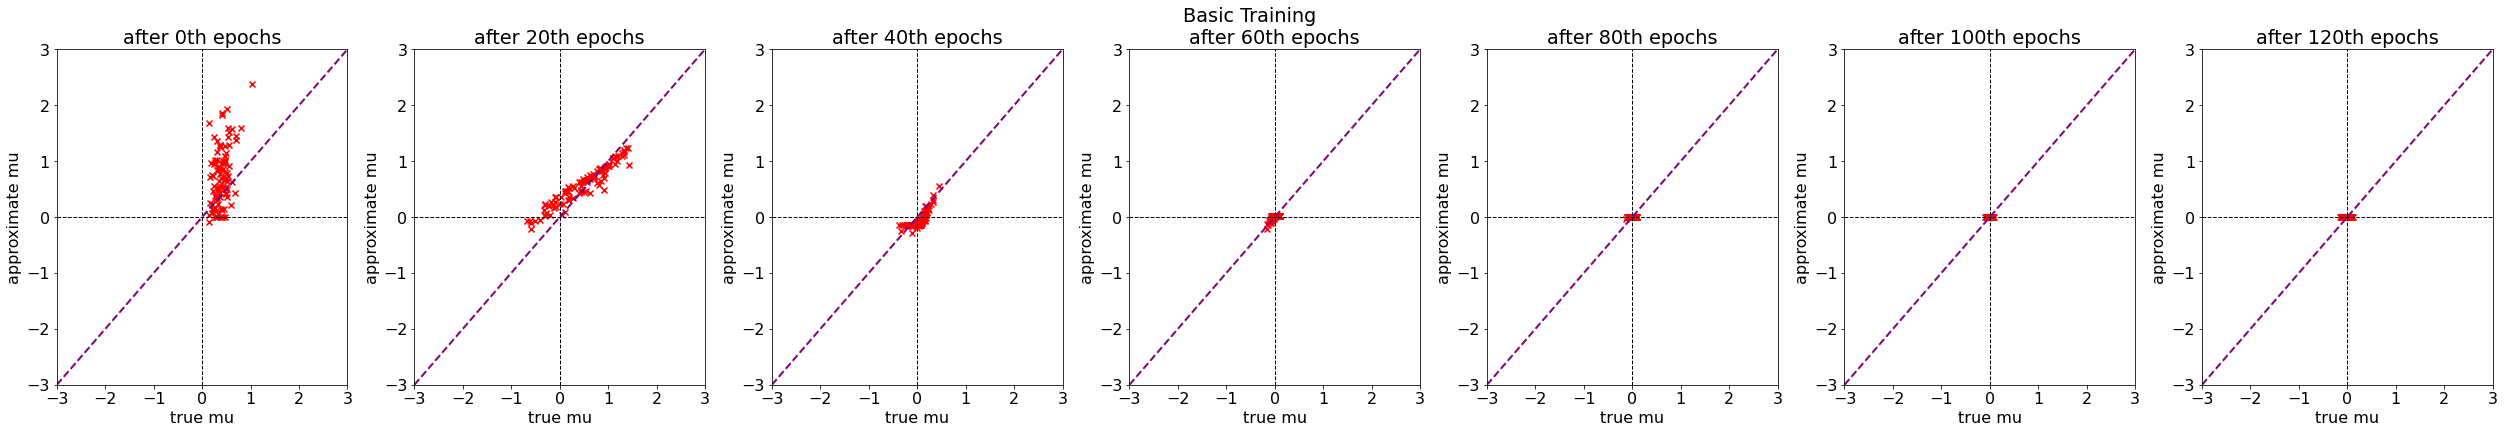

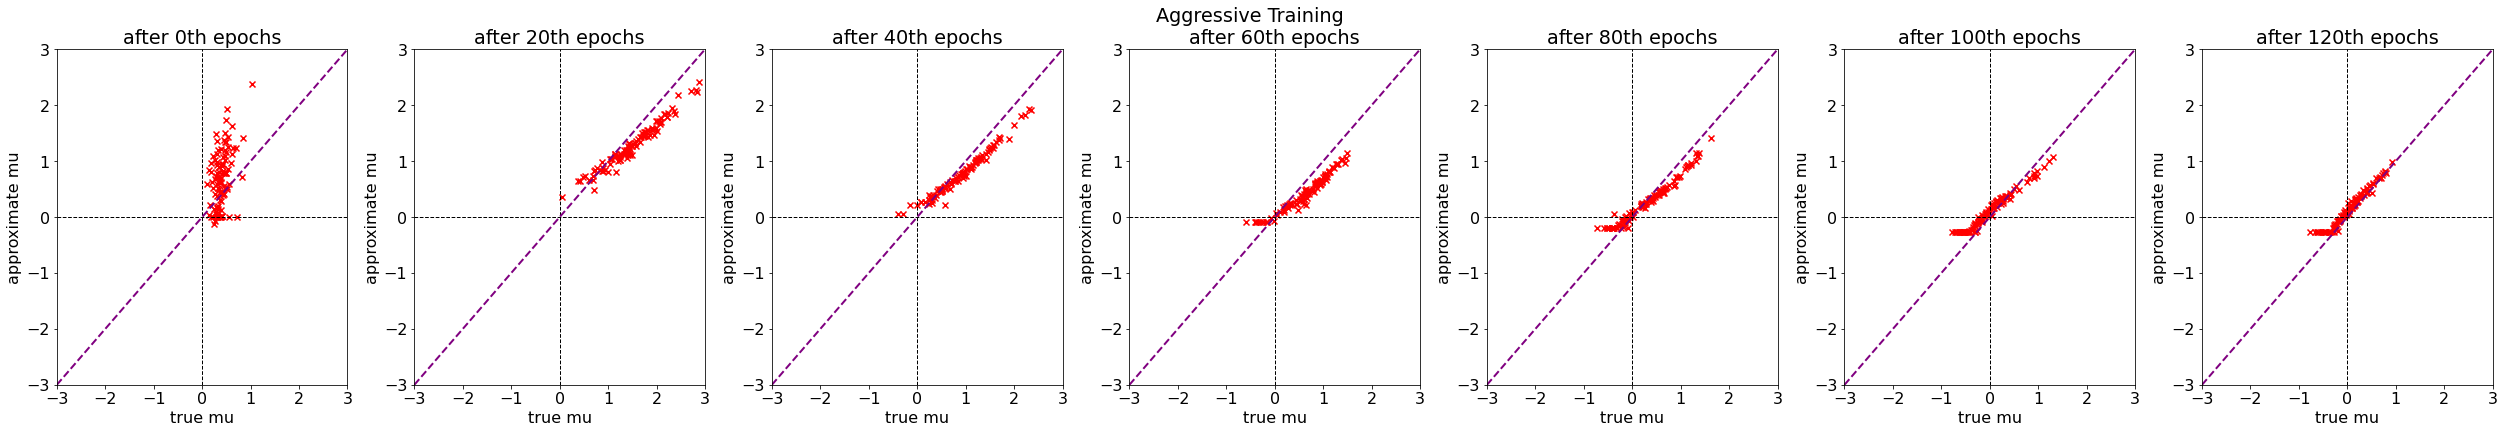

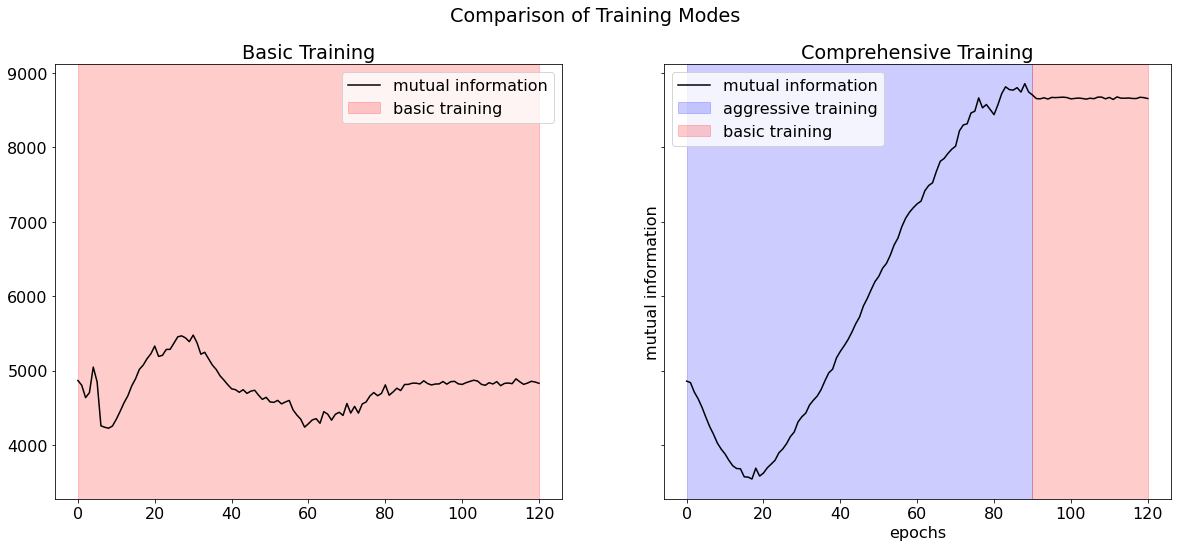

In [44]:
train_vae_given_hyperparameters(enc_intermediate_dim=[16,8,2], 
                                enc_learning_rate=0.005,
                                dec_learning_rate=0.002,
                                encoder_optimizer=optimizers.RMSprop,
                                decoder_optimizer=optimizers.RMSprop)

This experiment clearly illustrates how aggressive training can prevent posterior collapse. The top graph shows that during basic training both the true posterior and the approximate posterior rapidly shrink towards the origin,  which indicates that posterior collapse has occurred. On the other hand, the second plot shows that during aggressive training the points quickly orient themselves along the diagonal which indicates that the approximate posterior is in fact doing a good job at mimicking the true posterior. In other words, aggressive training has solved the problem of the encoder lagging behind the decoder. The final plot of the mutual information confirms this. The plot on the left shows that the mutual formation remains roughly constant throughout the entire basic training process. This means that the encoder hasn't learned a meaningful latent representation. In aggressive training, on the other hand, after a brief decrease in the mutual formation, it increases linearly over the course of roughly 70 epochs until it eventually flatlines. This means that the encoder has mananged to learn a meaningful latent representation. 

#### Experiment 2

This experiment is identical to experiment 1 except that the encoder is more complex (there are now twice as many nodes in each layer).

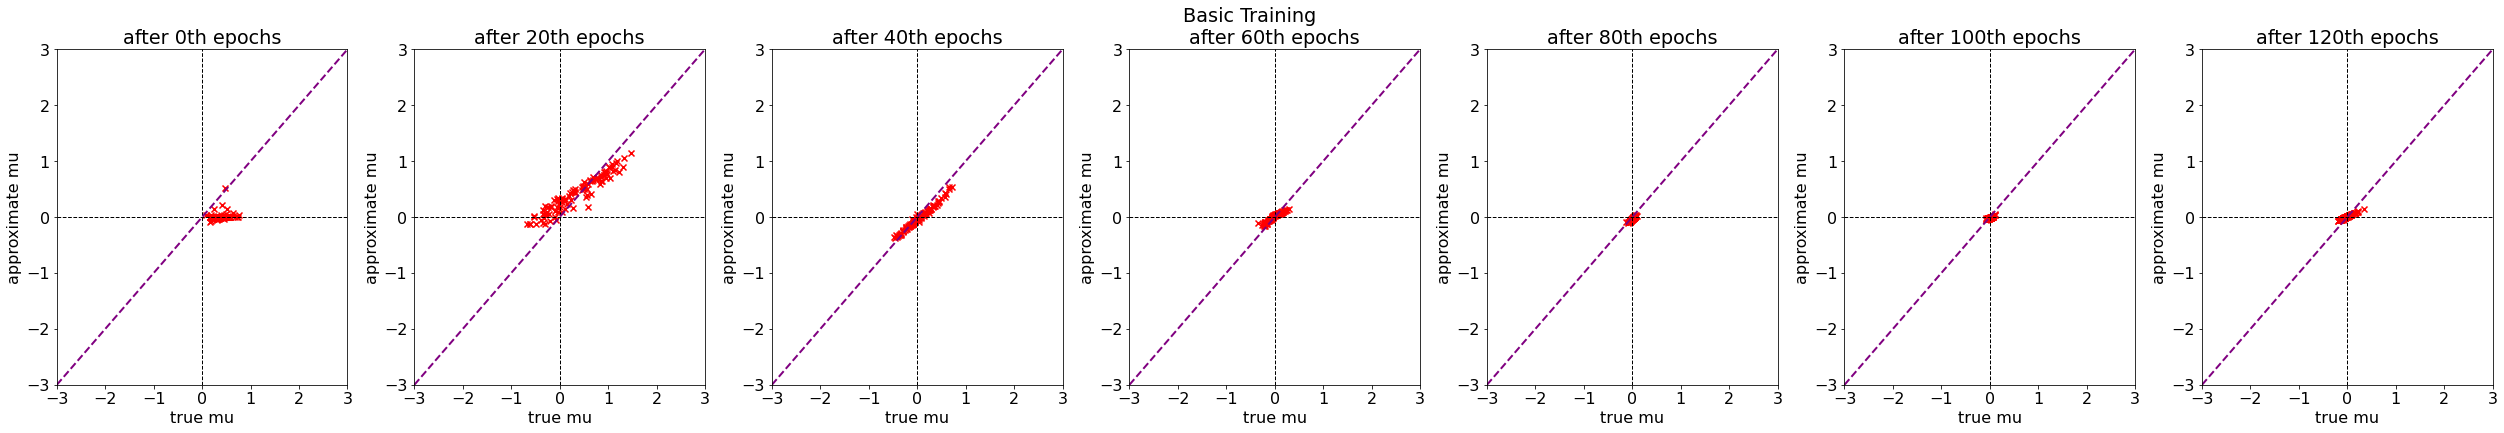

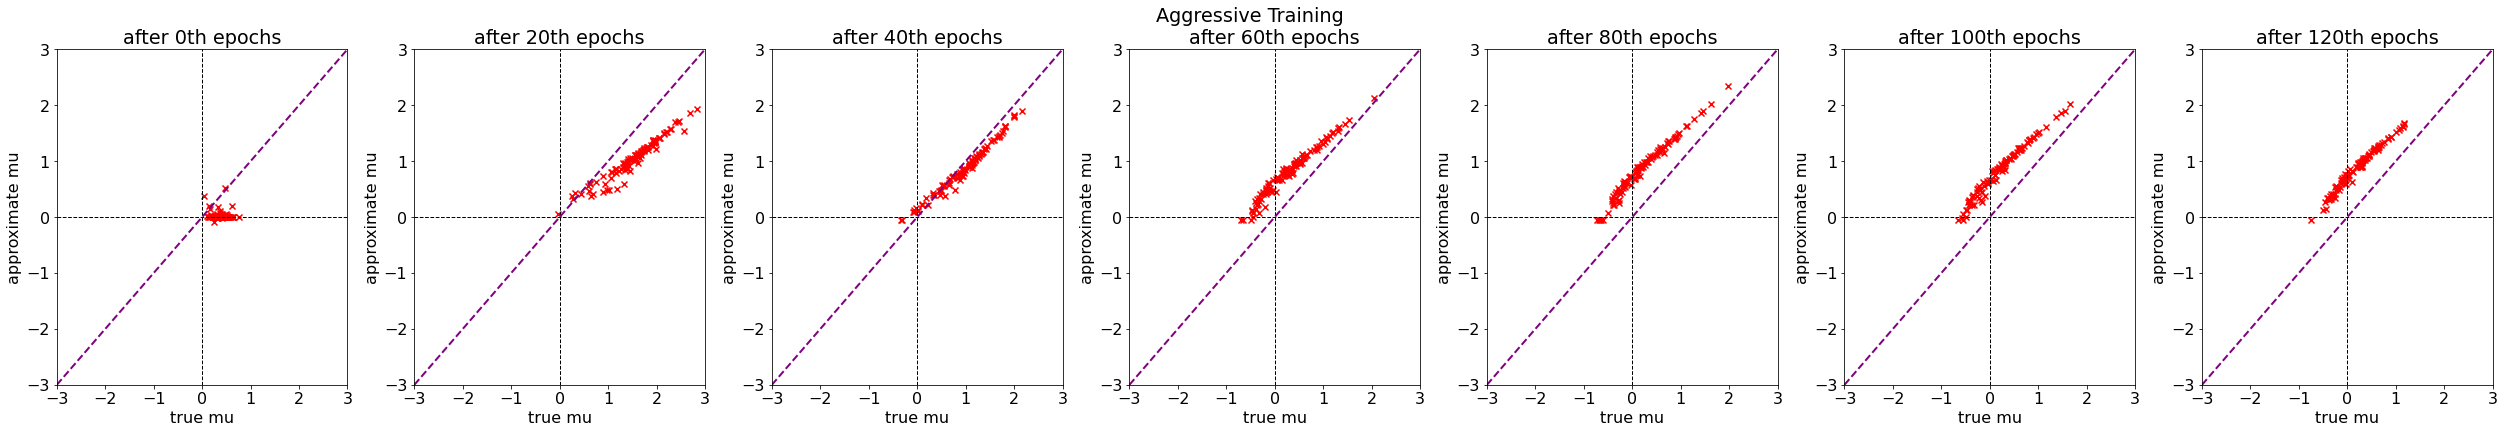

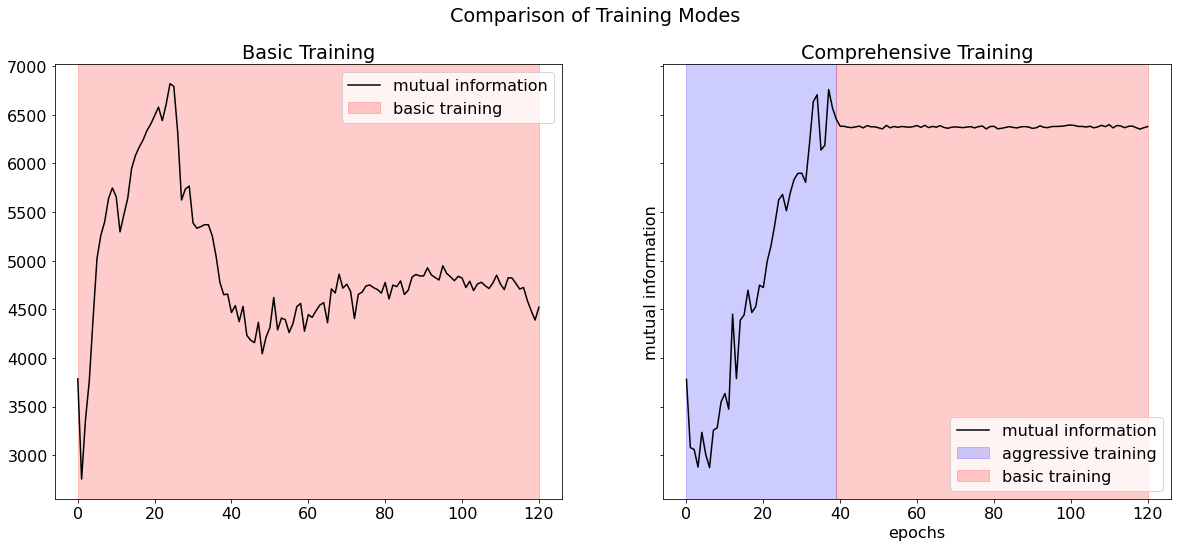

In [45]:
train_vae_given_hyperparameters(enc_intermediate_dim=[32,16,4], 
                                enc_learning_rate=0.005,
                                dec_learning_rate=0.002,
                                encoder_optimizer=optimizers.RMSprop,
                                decoder_optimizer=optimizers.RMSprop)

The fact that the encoder is more complex in this experiment leads to several key differences in the results. First, we notice that under basic training, the points initially fall along a diagonal and the mutual information initially increases. However, after around 20 epochs the model begins to collapse, as the points slowly shrink towards the origin and the mutual information declines significantly. On the other hand, under aggressive training, posterior collapse is once again avoided. The only difference here is that the mutual information plateaus after roughly half the number of iterations that it took an experiment 1. None of these observations is surprising because it's easier for the encoder to keep up with the decoder as the complexity of the encoder increases. 

#### Experiment 3

This experiment is identical to experiment 1 except that the encoder is less complex (there are now half as many nodes in each layer).

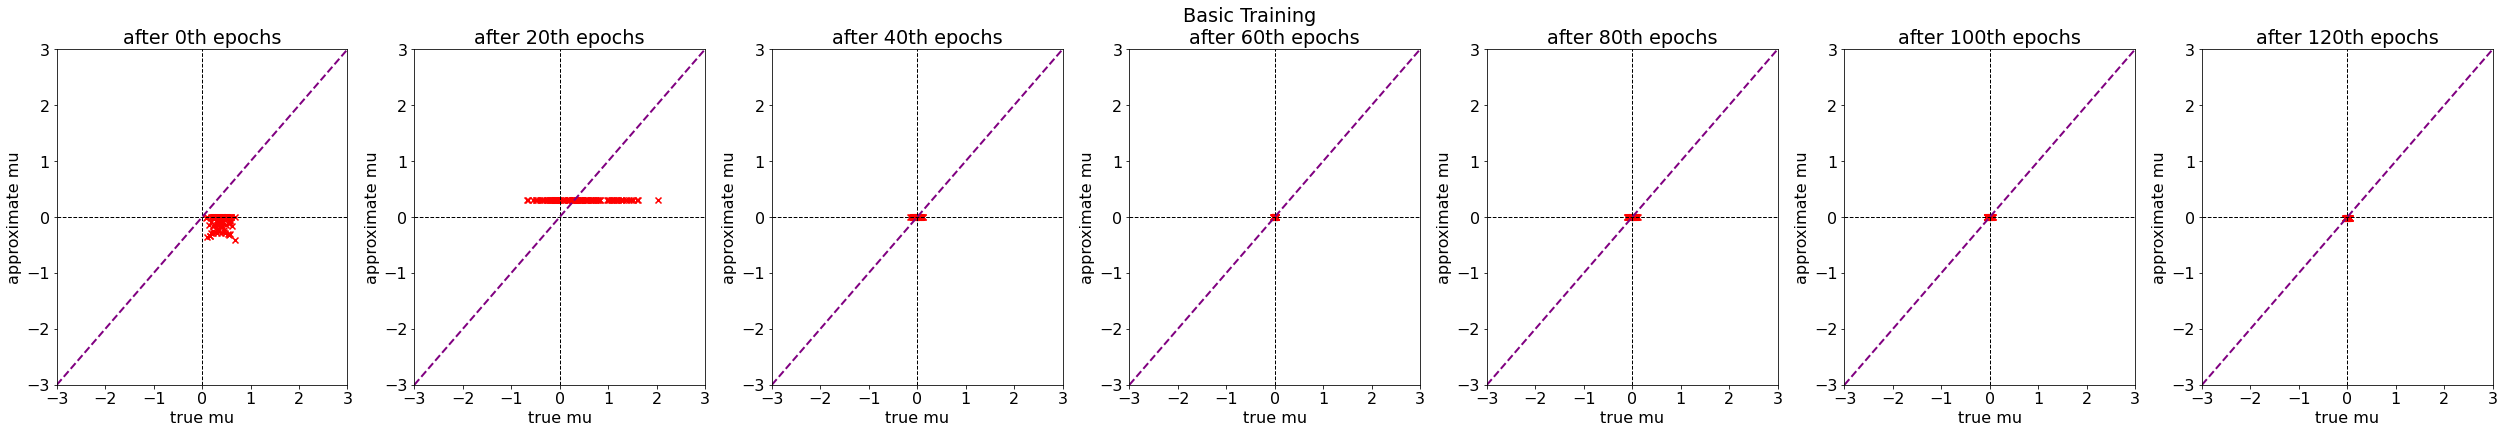

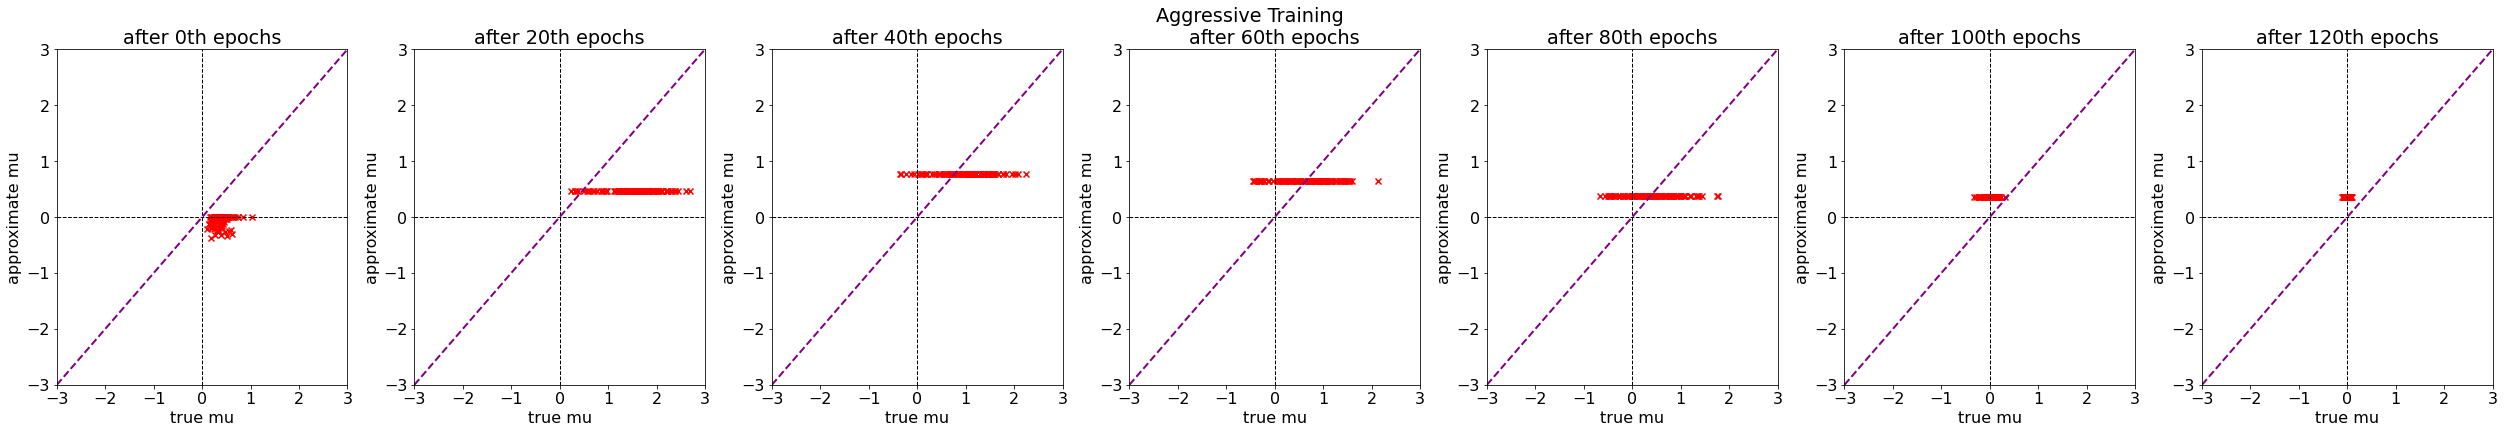

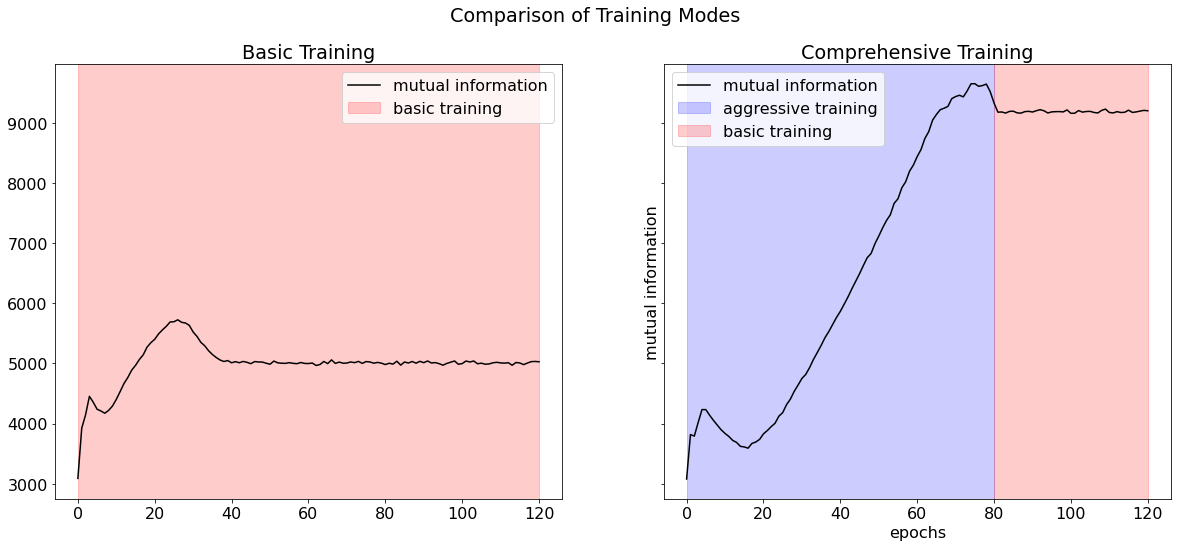

In [46]:
train_vae_given_hyperparameters(enc_intermediate_dim=[8,4,2], 
                                enc_learning_rate=0.005,
                                dec_learning_rate=0.002,
                                encoder_optimizer=optimizers.RMSprop,
                                decoder_optimizer=optimizers.RMSprop)

As expected, under basic training the model once again reaches a state of posterior collapse. What's different is that posterior collapse occurs even under aggressive training (at least according to the plot of the true posterior mean vs. the approximate posterior mean. Surprisingly, the mutual information plot contradicts this plot and suggests that the encoder has still managed to learn a meaningful latent representation of the data. But because the  posterior mean plot is more directly indicative of posterior collapse, it’s safe to assume that collapse has in fact taken place.)  Thus, this experiment demonstrates a case where aggressive training is unable to prevent posterior collapse. The reason for this is quite simple: if the inference network isn’t complex enough, it doesn’t have the flexibility needed to learn an approximate posterior distribution that adequately mimics the true posterior distribution -- and this is not a problem that can be solved by simply emphasizing the training of the encoder. 

To give an analogy, aggressive training is like a tutor. If a student is already familiar with the material,  then having a tutor spend more time reviewing the material could help improve the student’s understanding. However, if the student has never learned the material in the first place, then no matter how many extra practice problems the tutor gives the student, the student will never be able to master the material. 

#### Experiment 4

This experiment is identical to experiment 1 except that the learning rates have been changed (encoder learning rate has been increased by 4x, while decoder learing rate has been increased by 5x).

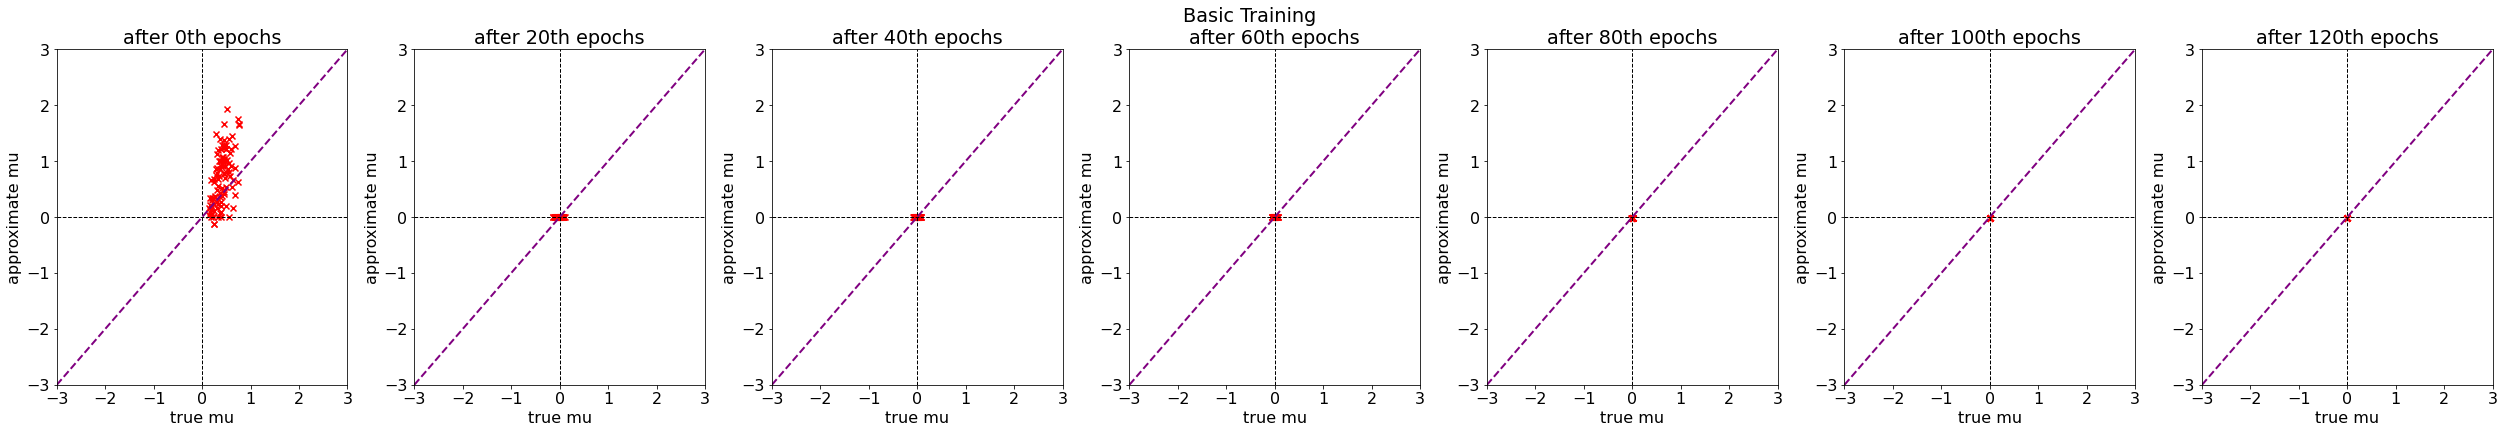

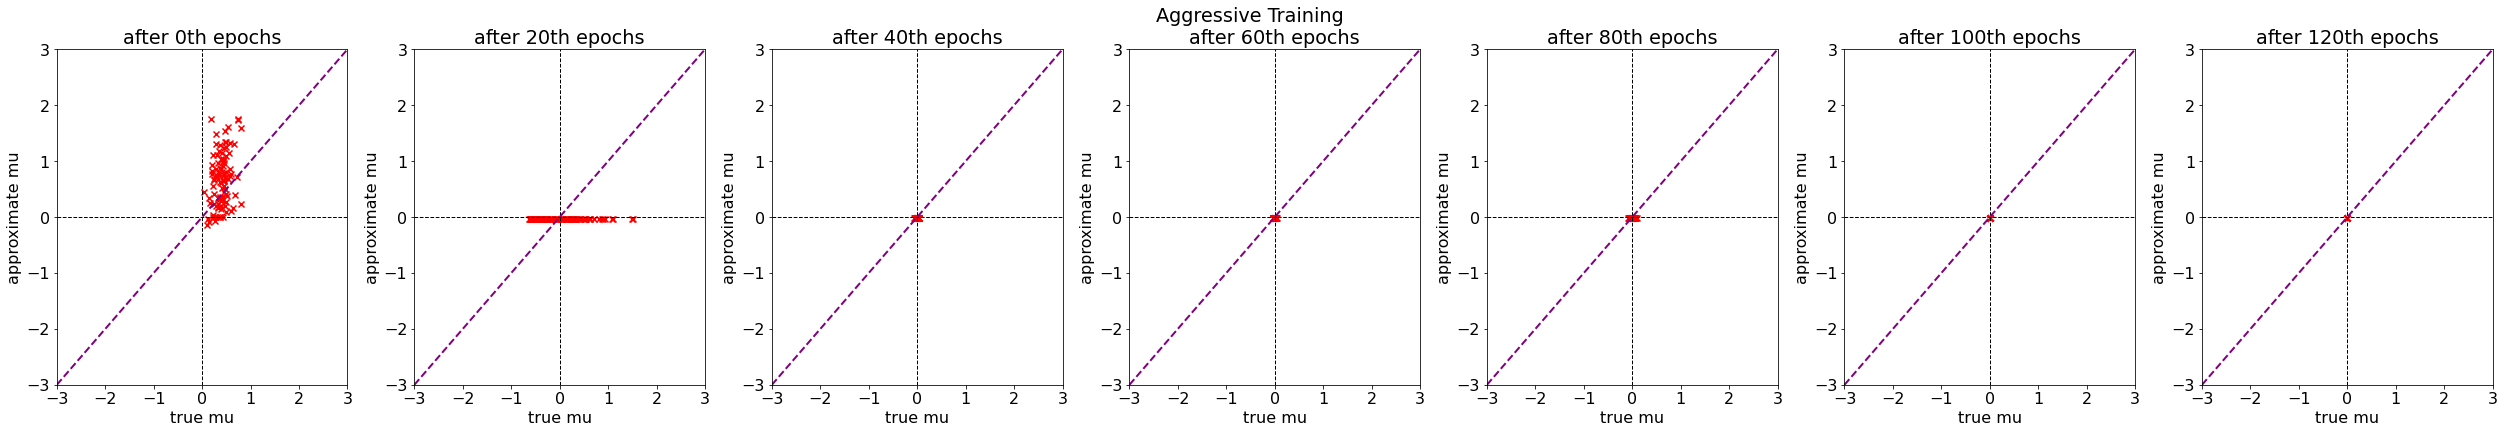

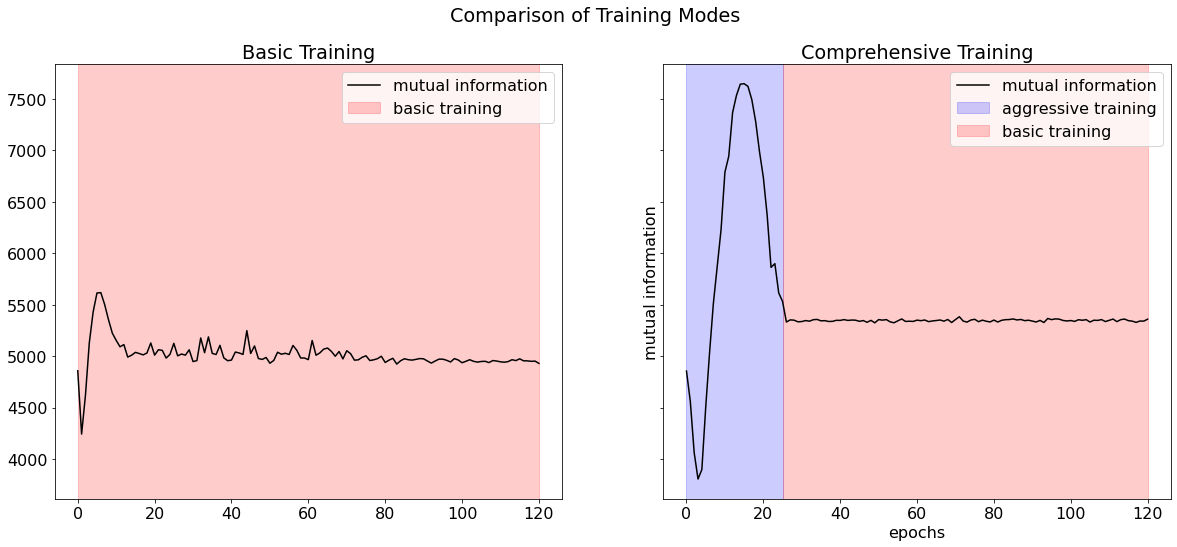

In [47]:
train_vae_given_hyperparameters(enc_intermediate_dim=[16,8,2], 
                                enc_learning_rate=0.02,
                                dec_learning_rate=0.01,
                                encoder_optimizer=optimizers.RMSprop,
                                decoder_optimizer=optimizers.RMSprop)

This experiment shows that like most deep learning models,  the performance of the VAE is highly sensitive to the chosen hyperparameters. In this case, changing the learning rates by less than an order of magnitude leads to posterior collapse even under aggressive training.

#### Experiment 5

This experiment is identical to experiment 1 except that the optimizer has been changed from RMSprop to Adam for both the encoder and decoder.

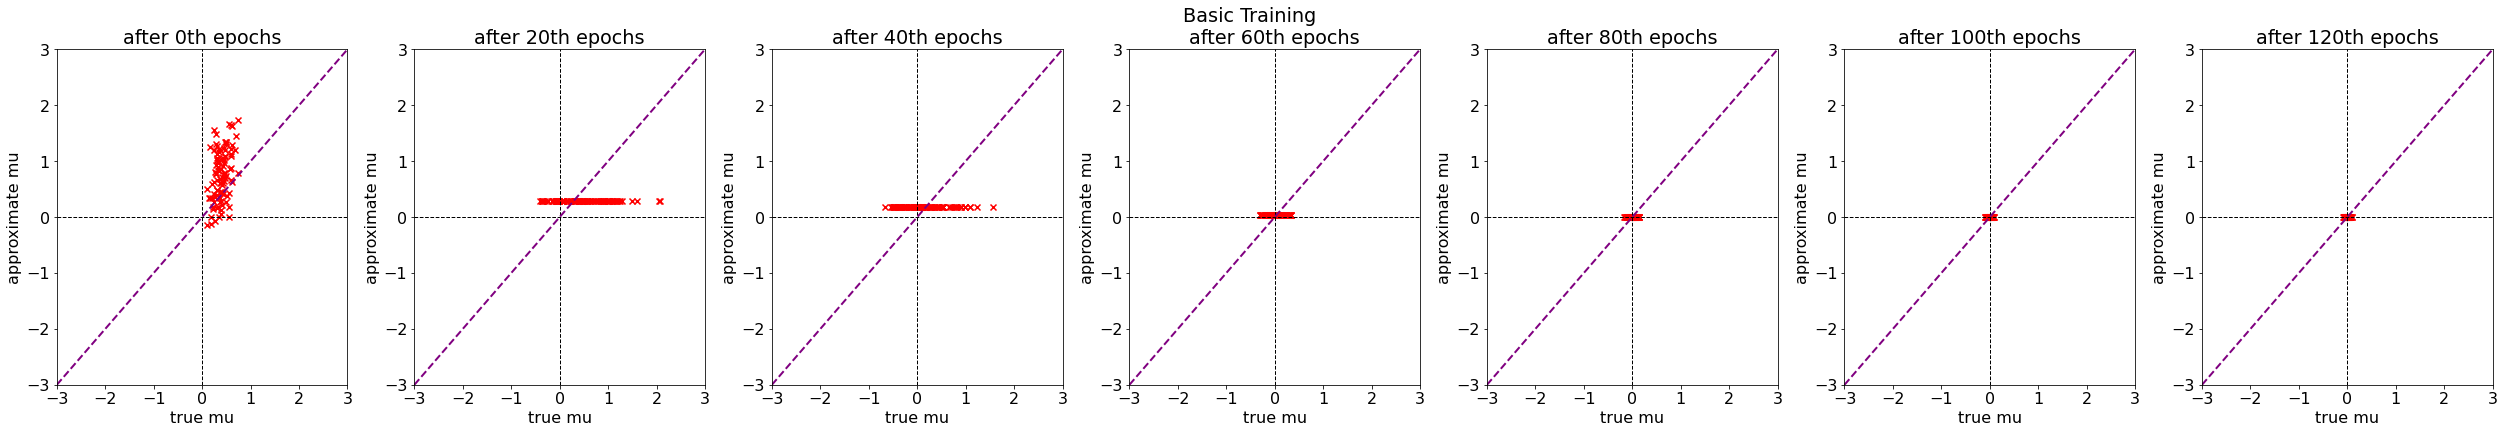

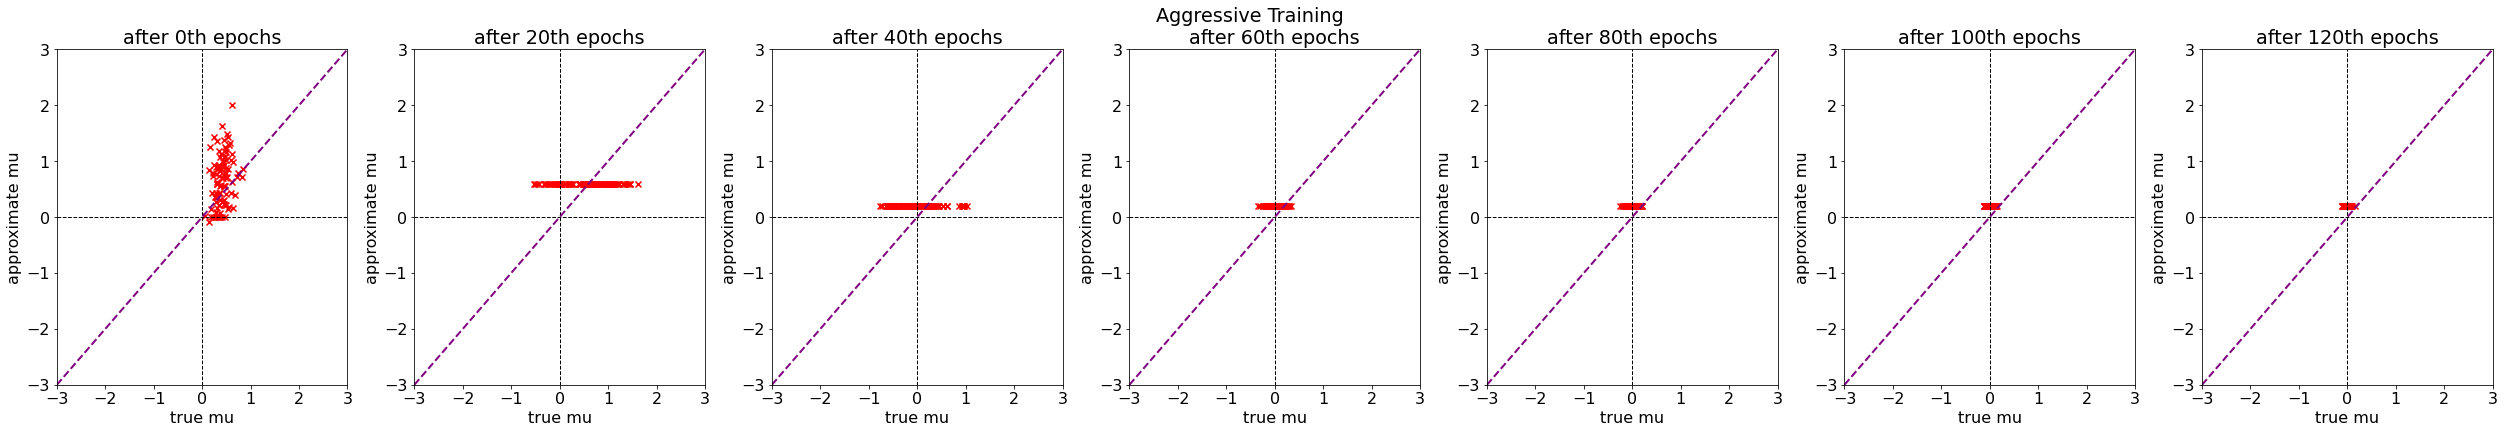

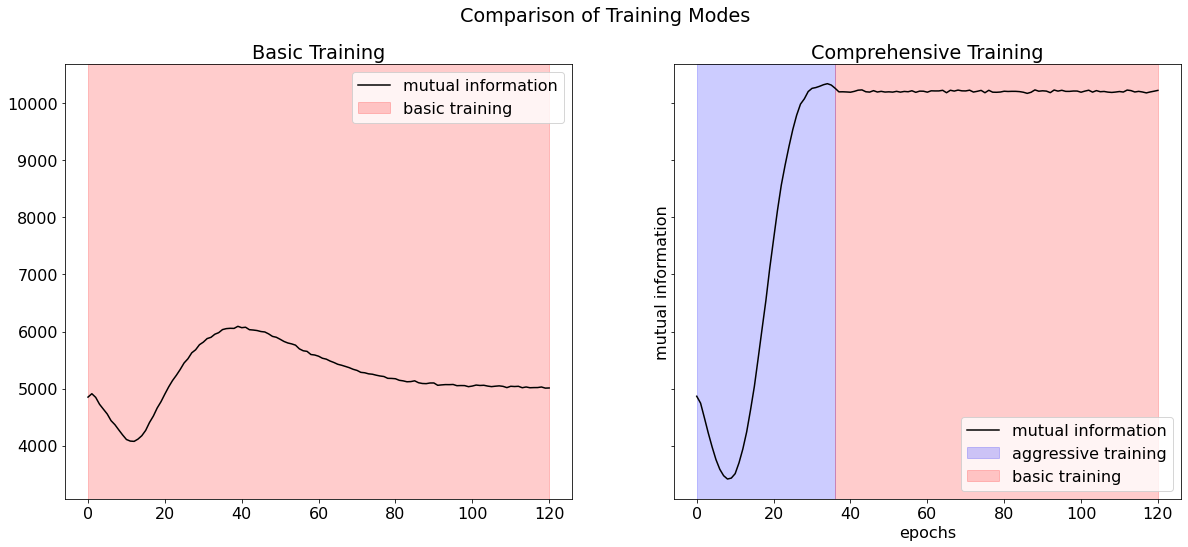

In [48]:
train_vae_given_hyperparameters(enc_intermediate_dim=[16,8,2], 
                                enc_learning_rate=0.005,
                                dec_learning_rate=0.002,
                                encoder_optimizer=optimizers.Adam,
                                decoder_optimizer=optimizers.Adam)

This experiment offers another example of how the performance of the VAE depends strongly on how the network is designed. In this case, simply replacing RMSprop with Adam is enough to cause posterior collapse under aggressive training. 

In [30]:
if False:
  epochs=120
  n_plots=6

  # Instantiate one optimizer for the encoder and another for the decoder.
  enc_optimizer = optimizers.RMSprop(learning_rate=0.005)
  dec_optimizer = optimizers.RMSprop(learning_rate=0.002)

  # param to build encoder and decoder
  input_dim = len(mean)
  enc_intermediate_dim=[16,8,2]
  dec_intermediate_dim=[2,12,16]
  bottleneck_dim=1

  # Comprehensive Training
  K.clear_session()
  tf.random.set_seed(207)
  encoder = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)    
  decoder = make_decoder(input_dim, dec_intermediate_dim)

  fig, axes = plt.subplots(1,n_plots+1,figsize=(35, 6))
  fig.suptitle("Aggressive Training", y=1.01)
  for i in range(n_plots+1):
      axes[i].set_title(f"after {int(epochs/n_plots)*(i)}th epochs")

  encoder, decoder, MI_agg, switch,_,_= comprehensive_training(encoder, decoder, 
                                                              enc_optimizer=enc_optimizer, dec_optimizer=dec_optimizer, 
                                                              train_dataset=train_dataset, vae_loss=vae_loss, axes=axes, 
                                                              epochs=epochs, n_plots=n_plots, 
                                                              min_epochs_aggressive=20, patience=3)
  plt.tight_layout()
  plt.show()

  # Basic Training
  K.clear_session()
  tf.random.set_seed(207)
  encoder = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)    
  decoder = make_decoder(input_dim, dec_intermediate_dim)

  fig, axes = plt.subplots(1,n_plots+1,figsize=(35, 6))
  fig.suptitle("Basic Training", y=1.01)
  for i in range(n_plots+1):
      axes[i].set_title(f"after {int(epochs/n_plots)*(i)}th epochs")
      
  encoder, decoder, MI_basic, _ , _ = basic_training(encoder, decoder, 
                                                    enc_optimizer = enc_optimizer, dec_optimizer =dec_optimizer, 
                                                    train_dataset=train_dataset, vae_loss=vae_loss, axes=axes, 
                                                    epochs=epochs, n_plots=n_plots)
  plt.tight_layout()
  plt.show()

In [31]:
if False:
  plt.rcParams.update({'font.size': 16})
  fig, ax = plt.subplots(1,2,sharey=True, figsize=(20,8))
  fig.suptitle("Comparison of Training Modes")

  ax[0].plot(MI_agg, c='k', label="mutual information")
  ax[0].axvspan(0, switch, alpha=0.2, color='blue', label="aggressive training")
  ax[0].axvspan(switch, epochs, alpha=0.2, color='red', label="basic training")
  ax[0].set_title("Comprehensive Training")
  ax[0].set_xlabel("epochs")
  ax[0].set_ylabel("mutual information")
  ax[0].legend()

  ax[1].plot(MI_basic, c='k', label="mutual information")
  ax[1].axvspan(0, epochs, alpha=0.2, color='red', label="basic training")
  ax[1].set_title("Basic Training")
  ax[1].legend()
  plt.show()

Finally, we run two tests to confirm that our VAE was trained correctly and that we correctly implemented the aggressive training algorithm.  

#### Check for correctness for the aggressive training implementation

Starting with decent decoder and new UNTRAINED encoder, if the code for basic and aggressive training works as expected, then:
- basic training => everything falls apart because the encoder won't be able to catch up
- aggressive training => encoder will catch up quickly to produce decent pair of encoder & decoder

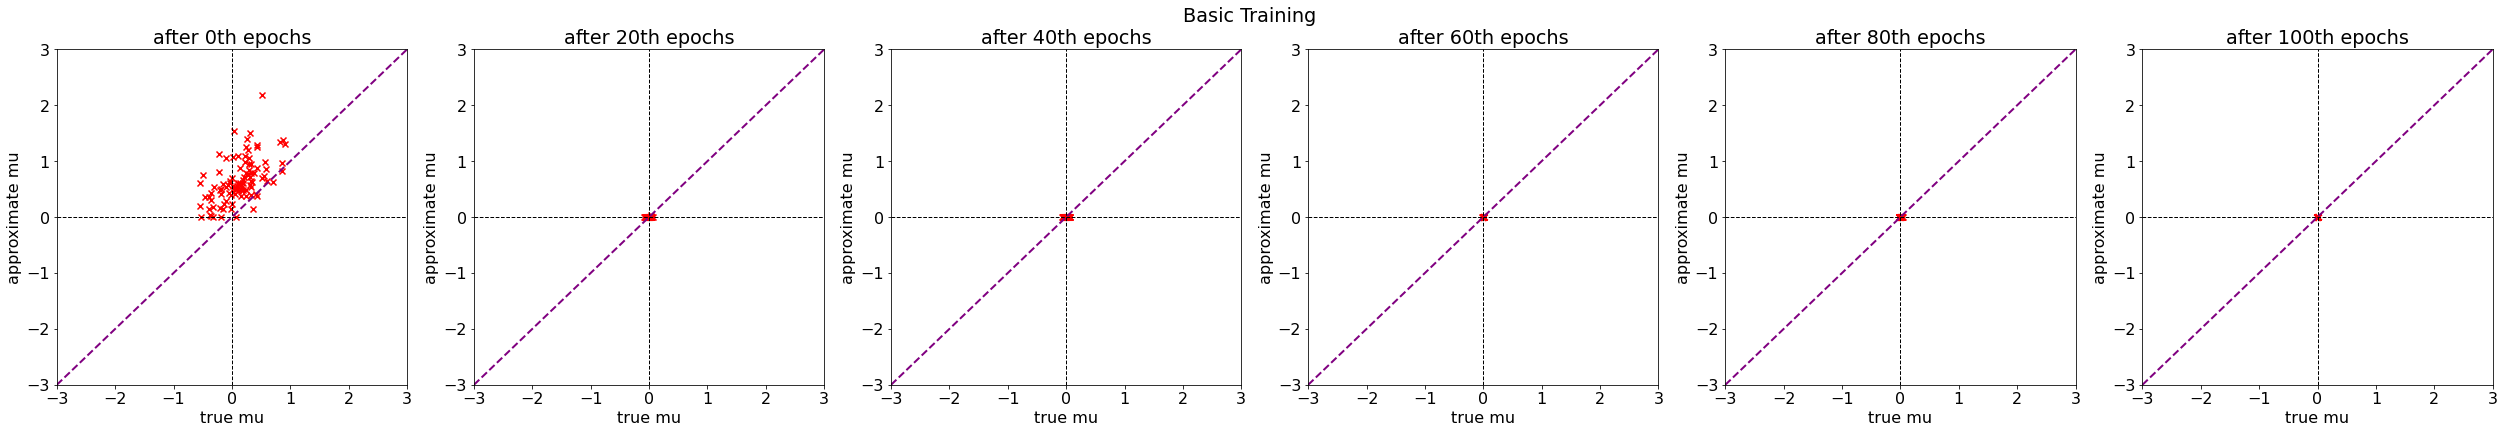

In [34]:
K.clear_session()
tf.random.set_seed(207)

# set constant variables
epochs=100
n_plots = 5

# Instantiate one optimizer for the encoder and another for the decoder.
enc_optimizer = optimizers.RMSprop(learning_rate=0.002)
dec_optimizer = optimizers.RMSprop(learning_rate=0.001)

# trained the VAE till we get a decent encoder & decoder
encoder = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)    
decoder = make_decoder(input_dim, dec_intermediate_dim)
encoder, decoder,_, _= comprehensive_training(encoder, decoder, 
                                              enc_optimizer=enc_optimizer, dec_optimizer=dec_optimizer,
                                              train_dataset=train_dataset, vae_loss=vae_loss, axes=axes, 
                                              epochs=epochs, n_plots=n_plots, show_plot=False,
                                              min_epochs_aggressive=20, patience=3)
# Basic Training
fig, axes = plt.subplots(1,n_plots+1,figsize=(35, 6))
fig.suptitle("Basic Training", y=1.01)
for i in range(n_plots+1):
    axes[i].set_title(f"after {int(epochs/n_plots)*(i)}th epochs")
    
# use trained decoder, and a new untrained encoder
encoder_new = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)  
encoder2, decoder2, _, _, _ = basic_training(encoder_new, decoder, enc_optimizer = enc_optimizer, dec_optimizer =dec_optimizer, 
                                             train_dataset=train_dataset, vae_loss=vae_loss, axes=axes, epochs=epochs, n_plots=n_plots)
plt.tight_layout()
plt.show()

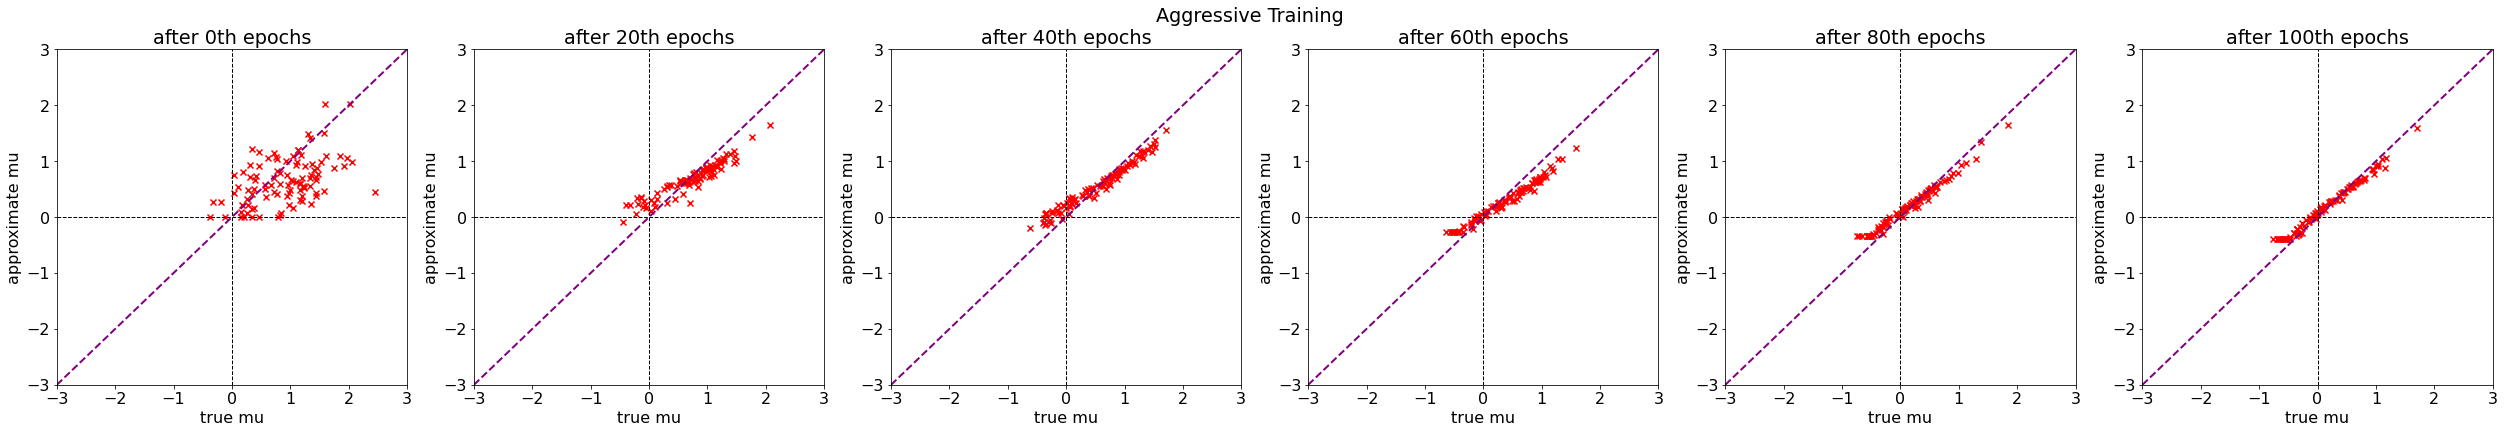

In [35]:
K.clear_session()
tf.random.set_seed(207)

# trained the VAE till we get a decent encoder & decoder
encoder = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)    
decoder = make_decoder(input_dim, dec_intermediate_dim)
encoder, decoder, _, _ = comprehensive_training(encoder, decoder,
                                                enc_optimizer=enc_optimizer, dec_optimizer=dec_optimizer, 
                                                train_dataset=train_dataset, vae_loss=vae_loss, axes=axes, 
                                                epochs=epochs, n_plots=n_plots, show_plot=False)
# Agressive Training
fig, axes = plt.subplots(1,n_plots+1,figsize=(35, 6))
fig.suptitle("Aggressive Training", y=1.01)
for i in range(n_plots+1):
    axes[i].set_title(f"after {int(epochs/n_plots)*(i)}th epochs")

# use trained decoder, and a new untrained encoder
encoder_new = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)  
encoder2, decoder2,_, _, _,_ = comprehensive_training(encoder_new, decoder,
                                                      enc_optimizer=enc_optimizer, dec_optimizer=dec_optimizer, 
                                                      train_dataset=train_dataset, vae_loss=vae_loss, axes=axes, 
                                                      epochs=epochs, n_plots=n_plots)
plt.tight_layout()
plt.show()


Passed the tests: aggressive training is able to force the new encoder to learn and catch up with the trained decoder while basic training cannot.

#### Check for correctness for the VAE

Decoder should be able to generate synthetic data with a similar distribution to the training data (starting with random samples from standard normal prior distribution).

In [36]:
# generate synthetic data for random normal
z_synthetic = np.random.normal(0., 1., size=1000)
np.mean(decoder2.predict(z_synthetic), axis=0)

array([0.93866235, 1.7831068 , 2.739449  ], dtype=float32)

Passed the test: The mean of the synthetically generated data is pretty close to the true mean (training data is generated from a multivariate Gaussian distribution with mean $[1,2,3]^T$)